## **Principles and Practice: Data Understanding**
#### For the book **The Applied ML Field Manual by Prithiviraj Damodaran**
----
In this notebook we will take a deep dive into data understanding. The inpisration for this dataset is from here [here](https://github.com/rudeboybert/JSE_OkCupid/blob/master/profiles.csv.zip)

**The ML Problem statement:**  Tag the members based on the self-declared profile attributes and preferences to enable member recommendations. Tags could be health-conscious, fitness-freak, 420-friendly, coffee-aficionado, wine connoisseur, marathon-runner etc..as shown below. 

<center> <img src="images/Tagged.png" style="width:700px;height:200px"></img></center>

**Goal of EDA** Taking one thread of that target problem statement we will explore the dataset to see what the life style, habits and diet choices of the members in San Fransisco reveal about their overall fitness and explore the possibilities of tagging members as **health conscious or not**. Note: An important life style factor to measure the fitness level: how active the members were ? is not among the attributes. But some preliminary analysis revealed that the hobbies mentioned in the essay text can help us extract a new feature "isActive". But thats a NLP task and out of scope for the current chapter.

**We will be using the battle tested tech stack for applied ML**

<center> <img src="images/IMG_1959.jpeg" style="width:420px;height:300px"></img></center>

In [1]:
%matplotlib inline
from utils.utils import gen_feature_specific_df
from utils.utils import mean_median_mode_plot
from utils.utils import custom_plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import pandas as pd
from pandas_profiling import ProfileReport
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

In [2]:
okc_profiles = pd.read_csv('profiles.csv')
okc_profiles.shape

(59946, 31)

## **Peek at the data**

In [6]:
okc_profiles.sample(1)

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
44807,24,fit,strictly vegetarian,socially,never,graduated from college/university,"i love food, kittens, and other stuff.","i just got a degree in art history, so.... i have no idea.",filling out forms.,"my precious, tiny ears.","the stranger, a happy death, dubliners, any and all sedaris.<br />\n<br />\namelie, the graduate, the big lebowski, napoleon dynamite.<br />\n<br />\ntwin peaks, it's always sunny in philadelphia, strangers with\ncandy, summer heights high.<br />\n<br />\nhttp://www.youtube.com/watch?v=21hwdnkzyq0&amp;feature=related<br />\n\n<br />\ni love food, as long as it's not meat or strawberries.",NaN,NaN,either being lazy on the internet or goofing around with friends at\na bar.,i named my cat after a character on the golden girls.,you wanna take a bicycle ride.,NaN,66.0,-1,NaN,2012-07-01-01-25,"san francisco, california",NaN,straight,likes dogs and has cats,agnosticism,f,capricorn but it doesn&rsquo;t matter,no,"english (fluently), spanish (poorly)",single


### Lets' get the features we are intetested in (based on common sense) from the full list of features

In [3]:
okc_profiles.shape

(59946, 31)

In [4]:
fitness_df = okc_profiles[['age', 'sex','education','job', 'offspring', 'location','income', 'diet', 'drinks','drugs', 'religion', 'smokes', 'pets','orientation','ethnicity', 'height', 'status', 'body_type']]
fitness_df.sample(3)

,age,sex,education,job,offspring,location,income,diet,drinks,drugs,religion,smokes,pets,orientation,ethnicity,height,status,body_type
4363,31,f,graduated from masters program,NaN,NaN,"san francisco, california",-1,NaN,socially,NaN,NaN,no,NaN,straight,white,67.0,single,thin
48324,53,m,graduated from high school,medicine / health,doesn&rsquo;t want kids,"san mateo, california",20000,mostly anything,not at all,never,other and very serious about it,no,likes dogs and likes cats,straight,white,73.0,single,fit
28318,54,m,NaN,transportation,has kids,"vallejo, california",-1,NaN,socially,never,catholicism and somewhat serious about it,yes,has dogs,straight,white,72.0,single,average


### This chapter mainly focusses only on EDA and not modelling but still as practice we will stash 20% of data for testing purposes.

In [5]:
fitness_df = fitness_df.sample(frac=1)
msk = np.random.rand(len(fitness_df)) < 0.8
test_df = fitness_df[~msk]
fitness_df = fitness_df[msk]
fitness_df.shape

(48094, 18)

### **Ratio of Male and Female members**

In [6]:
print(str(np.round(fitness_df[fitness_df['sex']== 'm'].count()[0] / fitness_df.shape[0],2) * 100) + "% :" + str(np.round(fitness_df[fitness_df['sex']== 'f'].count()[0] / fitness_df.shape[0],2) * 100) + "%") 

60.0% :40.0%


### **Mosaic Plot of Gender vs Orientation**

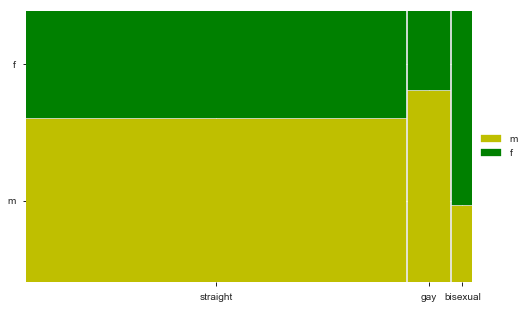

In [7]:
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 8, 5

props = {}
# Dictionary introduced here
col_dic = {'f': 'g', 'm': 'y'}
for x in ['gay', 'straight', 'bisexual']:
    for y, col in col_dic.items():
        props[(x, y)] ={'color': col}

mosaic(fitness_df, ['orientation', 'sex'], properties=props, labelizer=lambda k: '')

# Part added by me based on the linked answer
legenditems = [(plt.Rectangle((0,0),1,1, color=col_dic[c]), "%s" %c)
                 for i,c in enumerate(fitness_df['sex'].unique().tolist())]
plt.legend(*zip(*legenditems), ncol=1, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## **Full profile of the dataset**

* So we have ~60K (59946) rows and 17 columns (here in after features) the sample (here in after dataset).
* As we can see features can be numeric like income or non-numeric (here in after categorical) like job or diet.
* Machine learning algorithms are “happiest” when presented with data in a vector space. The reasons are not surprising: we can do Linear algebra and Vector math on them. For instance a ML model would be happy to see the fitness_df as a matrix of shape 59946 (rows) x 17 (columns) as opposed to a dataframe with numerical and categorical features. 
* So as a part of data understanding and data preparation we need to encode all non-numerical features into numerical. We will get to that in a moment.

In [8]:
profile = ProfileReport(fitness_df, title='Profiling Report')
profile

### **Examine the Datatypes of the features**

In [12]:
fitness_df.dtypes

age            int64  
sex            object 
education      object 
job            object 
offspring      object 
location       object 
income         int64  
diet           object 
drinks         object 
drugs          object 
religion       object 
smokes         object 
pets           object 
orientation    object 
ethnicity      object 
height         float64
status         object 
body_type      object 
dtype: object

### **Check for Missing values**

In [13]:
fitness_df.isna().any()

age            False
sex            False
education      True 
job            True 
offspring      True 
location       False
income         False
diet           True 
drinks         True 
drugs          True 
religion       True 
smokes         True 
pets           True 
orientation    False
ethnicity      True 
height         True 
status         False
body_type      True 
dtype: bool

In [14]:
fitness_df['body_type'].unique()

array(['fit', nan, 'average', 'athletic', 'skinny', 'curvy',
       'a little extra', 'thin', 'full figured', 'used up', 'overweight',
       'rather not say', 'jacked'], dtype=object)

In [15]:
fitness_df['income'].unique()

array([ 150000,   30000,      -1,   80000,   50000, 1000000,  100000,
         70000,  500000,   20000,   60000,   40000,  250000])

In [16]:
fitness_df['height'].unique()

array([68., 71., 72., 75., 65., 67., 61., 62., 69., 60., 74., 64., 70.,
       73., 66., 76., 63., 59., 57., 79., 58., 77., 90., 54., 78., 80.,
       95., 42., 36., 53., 81.,  1., 84., 82.,  6., 56., 55.,  4., 50.,
       83., nan, 94., 87., 48., 43., 92., 51., 37., 88., 89., 85., 49.,
       86.,  9.])

In [17]:
fitness_df['education'].unique()

array(['graduated from masters program',
       'graduated from college/university', 'graduated from ph.d program',
       nan, 'working on college/university', 'working on masters program',
       'college/university', 'graduated from high school',
       'working on two-year college', 'graduated from two-year college',
       'dropped out of college/university', 'graduated from law school',
       'working on ph.d program', 'graduated from med school',
       'working on space camp', 'two-year college', 'ph.d program',
       'graduated from space camp', 'dropped out of space camp',
       'dropped out of ph.d program', 'dropped out of two-year college',
       'working on med school', 'dropped out of masters program',
       'dropped out of high school', 'space camp', 'masters program',
       'high school', 'working on high school', 'working on law school',
       'med school', 'dropped out of med school',
       'dropped out of law school', 'law school'], dtype=object)

### **Measure of central tendency**
* For this exercise lets make the missing values as 0 and ignore them 
* We WON'T resorting to any imputations here.

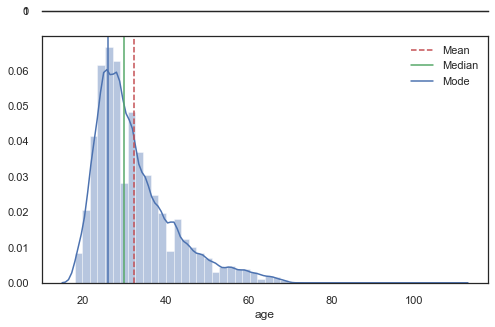

In [18]:
fitness_df['age'] = fitness_df['age'].fillna(0)
mean_median_mode_plot(fitness_df[fitness_df['age'] >0], 'age', False)

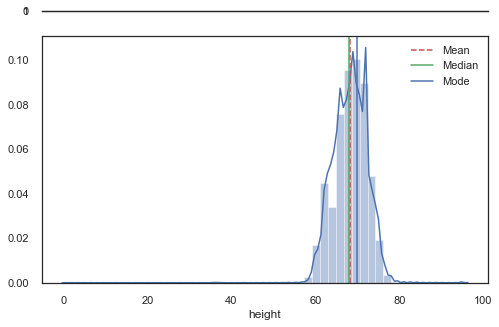

In [19]:
fitness_df['height'] = fitness_df['height'].fillna(0)
mean_median_mode_plot(fitness_df[fitness_df['height'] >0], 'height', False)

### **Handling missing values**
----

* **Understanding how the dataset was collected is an important pre-requisite to address the missing value problems. Here is a simple mental model to think about data collection in conjunction with missing values.**

<center><img src="images/Data collection.png" style="width:700px;height:550px"></img></center>



* **We can see that features like body_type, job, diet trun out to have NaN's**
* **But features can have missing values in 2 forms**
    * Features with NaN's (like **body_type** in our case)
    * Features having special filler values (like **income and height** which has -1 as a filler in our case)
    * Features having a mix of both NaN's and/or fillers
* **Handling missing values is actually a science as it depends the plausible reasons for missing in the 1st place.**
* **Values could be**. 
    * **Missing randomly**: Like in the case of data entry errors.
    * **Missing but with a pattern**: Like in the case of surveys were respondents skip certain questions.
        * For instance in census figures people with high income usually don't mention it. (self-censoring)
        * For instance in job applications people skip sexual orientation or ethnicity.
        * You could find a common thread.
    * **Missing by design**: Exceptions in the process that generated the data from which samples were taken.
        * Programming exceptions
        * Redacted values: Privacy, 3rd party censoring


<center><img src="images/Handling Missing.png" style="width:700px;height:550px"></img></center>

* **High level strategies to handle missing values are**
  * **Discard the instances (rows)**: If the proportion of the missing values is miniscule 
  * **Discard the feature (columns)**: If the proportion of the missing values is miniscule 
  * **Acquire missing values**: Going back to the business process or Subject matter expert who can possibly help in getting the missing values back.
  * **Imputation**: It is just a fancy way to fill missing values with some plausible value.
      * **Value Based imputation**
      * **Model Based imputation**
  * **Do nothing** : Another interesting strategy I learned from kagglers is to simply clear the NaNs and let the model learn interesting patterns. Tree Induction espcially Ensemble models have track record with this strategy. Nonetheless we can't premeditate anything now as it is too early.
      
**References**:      
1. http://www.stat.columbia.edu/~gelman/arm/missing.pdf
2. http://www.stat.uchicago.edu/~eichler/stat24600/Admin/MissingDataReview.pdf


In [20]:
col_dtypes = zip(fitness_df.columns,fitness_df.dtypes)
for col, dtype in col_dtypes:
    if dtype == 'O':
        fitness_df[col] = fitness_df[col].fillna('ans_skipped')    # for EDA purposes lets use a filler
    else:
        fitness_df[col] = fitness_df[col].fillna(0)                # We are simply going make the missing numeric values 0 and ignore them as they are only minuscule

fitness_df.isna().any()

age            False
sex            False
education      False
job            False
offspring      False
location       False
income         False
diet           False
drinks         False
drugs          False
religion       False
smokes         False
pets           False
orientation    False
ethnicity      False
height         False
status         False
body_type      False
dtype: bool

#### Some observations
* After cleaning misisng values, Body_type field has a 'skipped' (no answer) and a 'rather not say' (prefer not to disclose) values
* Whoever skipped this question or chose to say 'rather not say' was probably embarrased to mention this ? 
* Because its a dating site and looks play a major role and hiding body_type isnt exactly putting your sexy foot forward. 
* Should you replace 'skipped'(no answer) with a 'rather not say' ? Probably not !

### **Handling Class Imbalances in a classification problem**
* The attribute **body_type** could be used as a target variable to frame this is a multiclass classification problem or we could derive our target by grouping them in 2 categories: Obese and Non-Obese.
* Note: For our argument we consider the widely accepted social definition of obesity: “Weight above what's considered healthy, measured BMI”.
* We could **ignore ans_skipped** and **rather not say** group **overweight, full figured, curvy and a little extra** under **obese** category and the rest as *Non-obese*.
* About **75% of the members will come under non-obese** (*fit, athletic, thin, skinny, average and jacked*).
* 75%:25% non-obese to obese is called class imbalance and it is a problem. 
* **Why Imbalance is a problem ?**
    * The dataset is said to be imbalanced when distribution of the classes in the target attribute biased or skewed. The distribution can vary from a slight bias to a severe imbalance where there is one example in the minority class for hundreds, thousands, or millions of examples in the majority class or classes. This is a challenge because most of the machine learning algorithms operate under the assumption that fairly equal number of samples exists each class. This results in models with poor predictive performance, specifically for the minority class simply because the model would have seen more of the majority class.

In [21]:
fitness_df['body_type'].value_counts()

average           11777
fit               10149
athletic          9487 
ans_skipped       4229 
thin              3779 
curvy             3174 
a little extra    2137 
skinny            1411 
full figured      804  
overweight        358  
jacked            351  
used up           277  
rather not say    161  
Name: body_type, dtype: int64

### **The Mental Model for tackling imbalance**
* Instead of we doing the heavy lifting by synthetic data generation, we always could relegate handling imbalance to a smart algorithm in the model training stage along with some model evaluation metrics that are sensitive to imbalance, which is exactly what we are going to do.

<center><img src="images/Imbalance.png" style="width:500px;height:600px"></img></center>

### **Handling Extreme Values and Outliers**
----
* All natural features numerical can have out of ordinary values for a given problem domain, 
    * Age years: Any value more 100 or less than 18 should raise a suspicion. These are **extreme values** 
    * Age years: Any value in the range of 65-75 years and these are **outliers**
    * Height in inches: with anything more than 100 inches or less than 40 inches for an adult should raise a suspicion, These are **extreme values** 
    * Height in inches: Any value in the range of 75-80 inches These are **outliers** 
* **Usually extreme values are implausible and the most popular strategy is to discard them**
* **Outliers are hanlled on a case to case basis and problem domain**
* **Also we will see why distribution plot with mean and SD is not good way to diagnose if the dataset has outliers.** 

### Lets compare the viz of outliers in Age and Height using a distribution plot and a box plot
* Box and whisker plots (or box plots in short) were invented by John Tukey exclusively i to visualise median and IQR, as you can see a box plot better shows the outliers and extreme values
* Here is a good explanation on how to find out outliers and extreme values using Box plots and Tukey fences.
    * https://www.purplemath.com/modules/boxwhisk3.htm
*  The "interquartile range", abbreviated "IQR", is just the width of the box in the box-and-whisker plot. That is, IQR = Q3 – Q1 and any values below Q1 – 1.5×IQR or above Q3 + 1.5×IQR is considered an outliers and extreme values. These values are called the **Tukey Fences**

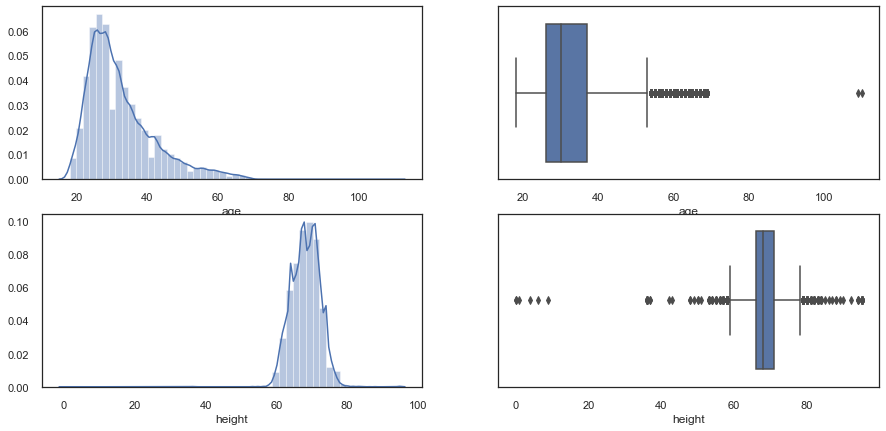

In [22]:
f, axes = plt.subplots(2, 2, figsize=(15,7))
sns.distplot(fitness_df['age'], ax=axes[0,0])
sns.boxplot(x=fitness_df['age'], ax=axes[0,1])
sns.distplot(fitness_df['height'], ax=axes[1,0])
sns.boxplot(x=fitness_df['height'], ax=axes[1,1])
plt.show()

In [23]:
def discard_extreme_values(df):
    
    # Lets see what % of the Age-wise Outliers in the dataset and discard if they are minuscule as suspected
    pct_outliers_age = df[(df['age'] > 70) | (df['age'] < 18)].shape[0] * 100 / df.shape[0]
    if pct_outliers_age < 1:         
        df = df[~((df['age'] > 70) | (df['age'] < 18))]
        
    # Lets what % of the Height-wise Outliers in the dataset and discard if they are minuscule as suspected        
    df['height'] = df['height'] * 0.083   # Inches to feet
    pct_outliers_height = df[(df['height'] > 7) | (df['height'] < 4)].shape[0] * 100 / df.shape[0]
    if pct_outliers_height < 1:
        df = df[~((df['height'] > 7) | (df['height'] < 4))]    
        
    return df

In [24]:
def discard_outliers_IQR(df):
    
    # Age
    Q1 = fitness_df['age'].describe()[4]
    Q3 = fitness_df['age'].describe()[6]
    IQR = Q3-Q1
    df = df[~((df['age'] < Q1- (1.5 * IQR)) | (df['age'] > Q3 + (1.5 * IQR)))]
    
    #Height
    Q1 = fitness_df['height'].describe()[4]
    Q3 = fitness_df['height'].describe()[6]
    IQR = Q3-Q1
    df = df[~((df['height'] < Q1- (1.5 * IQR)) | (df['height'] > Q3 + (1.5 * IQR)))]
        
    return df

#### Discarding outliers and extreme values
*  **In the figure above values immediately outside of the box are the outliers and the values at the far end are extreme values**
*  With Tukey fences we may have to discard folks who are "older" for the general crowd in a online dating app say who are in late 50s and early 60s.
*  With Tukey fences we may have to discard folks who are "taller" for the general crowd.
*  Both are outright baseliess discriminations against certain individuals aka a biased approach.
*  So we will only be discarding the outliers.

In [25]:
fitness_df = discard_extreme_values(fitness_df)

### **Age Distrbution of the members Male vs Female**

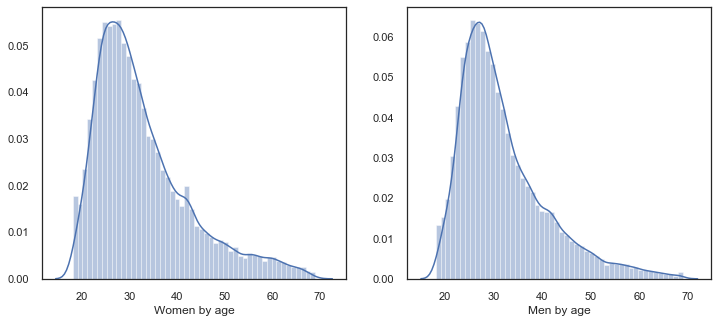

In [26]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(fitness_df[fitness_df['sex']=='f']['age'], hist=True, ax=axes[0])
axes[0].set_xlabel("Women by age")
sns.distplot(fitness_df[fitness_df['sex']=='m']['age'], hist=True, ax=axes[1])
axes[1].set_xlabel("Men by age")
plt.show()

### **Height Distrbution of the members Male vs Female**

In [27]:
fitness_df['height'].describe()

count    48045.000000
mean     5.668317    
std      0.320841    
min      4.067000    
25%      5.478000    
50%      5.644000    
75%      5.893000    
max      6.972000    
Name: height, dtype: float64

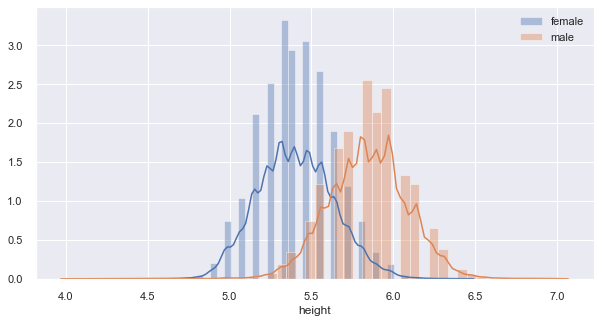

In [28]:
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(fitness_df[fitness_df['sex']=='f']['height'], hist=True)
sns.distplot(fitness_df[fitness_df['sex']=='m']['height'], hist=True)
plt.legend(['female', 'male'])
plt.show()

### **Features Viz by values**

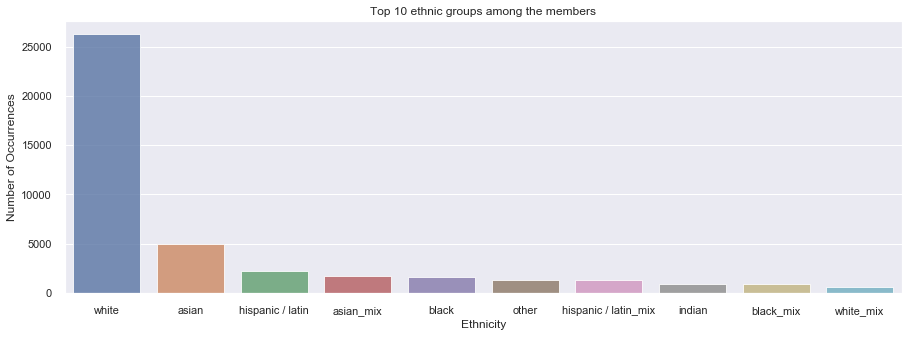

In [29]:
def get_ethnics(ethnicity):
    if ',' in ethnicity:
        pos = ethnicity.find(',')
        return ethnicity[0:pos] + '_' + 'mix'
    else:
        return ethnicity
    
fitness_df['ethnicity'] = fitness_df['ethnicity'].apply(get_ethnics) 

ethnic_count  = fitness_df[fitness_df['ethnicity']!='ans_skipped']['ethnicity'].value_counts()
ethnic_count = ethnic_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(ethnic_count.index, ethnic_count.values, alpha=0.8)
plt.title('Top 10 ethnic groups among the members')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ethnicity', fontsize=12)
plt.show()

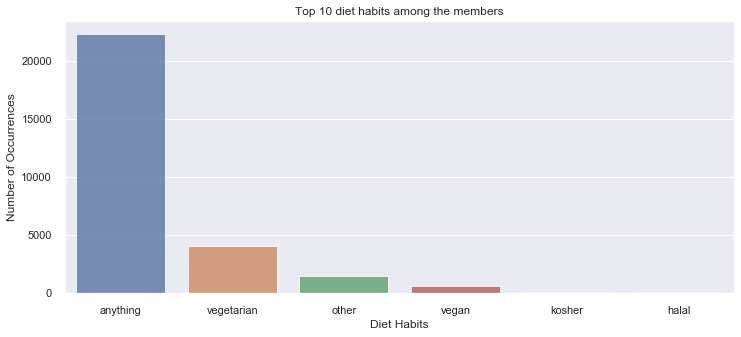

In [30]:
def get_diet(diet):
    if ' ' in diet:
        pos = diet.find(' ')
        return diet[pos+1:]
    else:
        return diet
    
fitness_df['diet'] = fitness_df['diet'].apply(get_diet) 

diet_count  = fitness_df[fitness_df['diet']!='ans_skipped']['diet'].value_counts()
diet_count = diet_count[:10,]
plt.figure(figsize=(12,5))
sns.barplot(diet_count.index, diet_count.values, alpha=0.8)
plt.title('Top 10 diet habits among the members')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Diet Habits', fontsize=12)
plt.show()

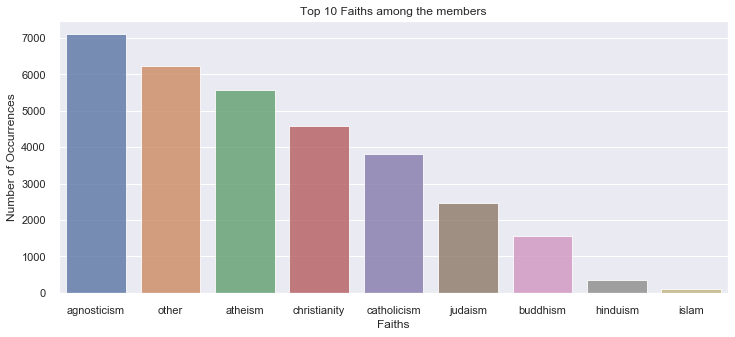

In [31]:
def get_religion(religion):
    if ' ' in religion:
        return religion.split(' ')[0]
    else:
        return religion
    
fitness_df['religion'] = fitness_df['religion'].apply(get_religion) 

religion_count  = fitness_df[fitness_df['religion']!='ans_skipped']['religion'].value_counts()
religion_count  = religion_count[:10,]
plt.figure(figsize=(12,5))
sns.barplot(religion_count.index, religion_count.values, alpha=0.8)
plt.title('Top 10 Faiths among the members')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Faiths', fontsize=12)
plt.show()

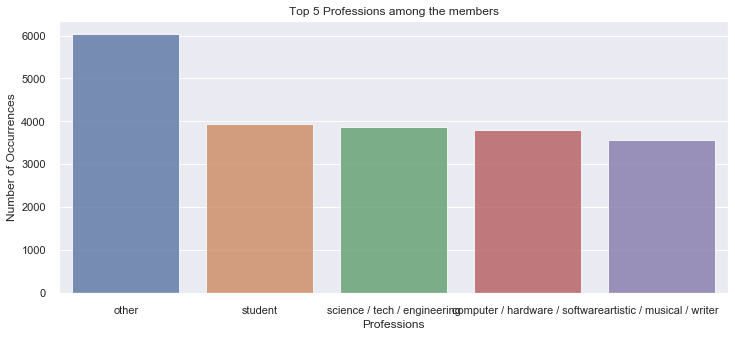

In [32]:
job_count  = fitness_df[fitness_df['job']!='ans_skipped']['job'].value_counts()
job_count  = job_count[:5,]
plt.figure(figsize=(12,5))
sns.barplot(job_count.index, job_count.values, alpha=0.8)
plt.title('Top 5 Professions among the members')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Professions', fontsize=12)
plt.show()

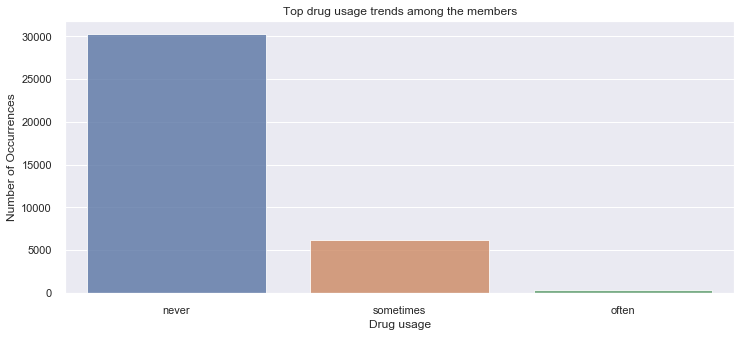

In [33]:
drug_count  = fitness_df[fitness_df['drugs']!='ans_skipped']['drugs'].value_counts()
drug_count  = drug_count[:5,]
plt.figure(figsize=(12,5))
sns.barplot(drug_count.index, drug_count.values, alpha=0.8)
plt.title('Top drug usage trends among the members')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Drug usage', fontsize=12)
plt.show()

In [34]:
s = fitness_df['drugs'].astype('category', categories=["never", "sometimes", "often", "ans_skipped"])
print(s.unique())
print(s.cat.codes.unique())

[never, ans_skipped, sometimes, often]
Categories (4, object): [never, ans_skipped, sometimes, often]
[0 3 1 2]


## **Feature Interplay Viz**

### **What does Drug usage say about overall Fitness and Obesity levels ?**
* We will be using a variant of whats called a [Mosaic plot or a Mekko plot or Marimekko plot](https://en.wikipedia.org/wiki/Mosaic_plot), it looks very similar to a stacked bar plot but there are minor differences.

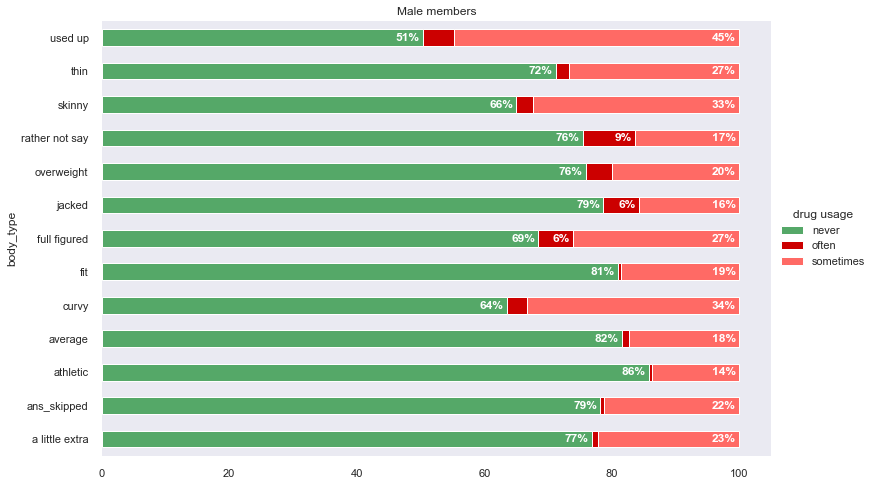

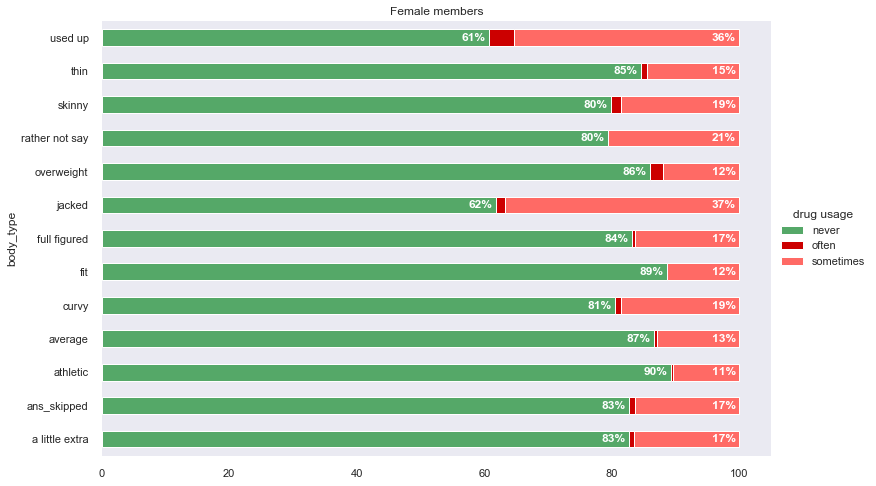

In [35]:
fitness_trn_drugs = gen_feature_specific_df(fitness_df,'body_type', 'drugs', 'm')
cols = list(fitness_trn_drugs.columns)
cols.remove('body_type')
cols.remove('sex')
cols.remove('ans_skipped')
fitness_trn_drugs = pd.pivot_table(fitness_trn_drugs, index=['body_type'],values=cols, aggfunc=np.sum)
color_list = ['g', '#cc0000', '#ff6a65']
ax = custom_plot(fitness_trn_drugs, "drug usage", "Male", color_list)

fitness_trn_drugs = gen_feature_specific_df(fitness_df,'body_type', 'drugs', 'f')
cols = list(fitness_trn_drugs.columns)
cols.remove('body_type')
cols.remove('sex')
cols.remove('ans_skipped')
fitness_trn_drugs = pd.pivot_table(fitness_trn_drugs, index=['body_type'],values=cols, aggfunc=np.sum)
color_list = ['g', '#cc0000', '#ff6a65']
ax= custom_plot(fitness_trn_drugs, "drug usage", "Female", color_list)

### **What does Alcohol intake say about Fitness and Obesity levels ?**

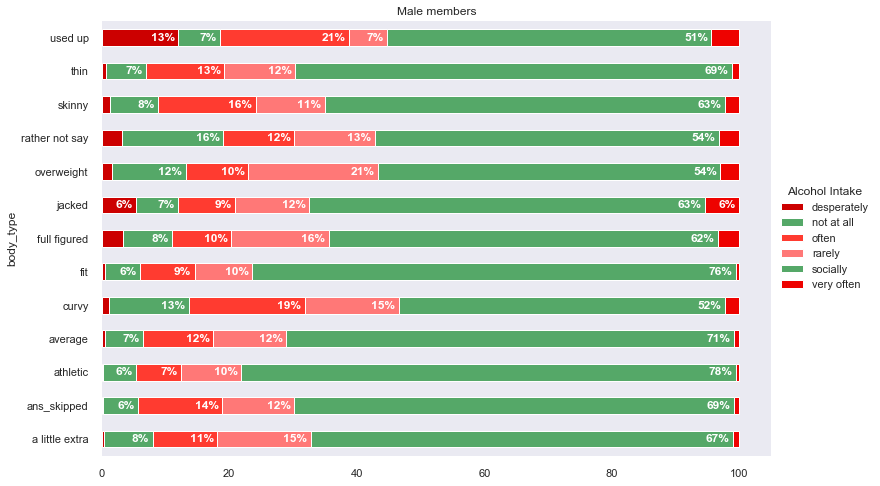

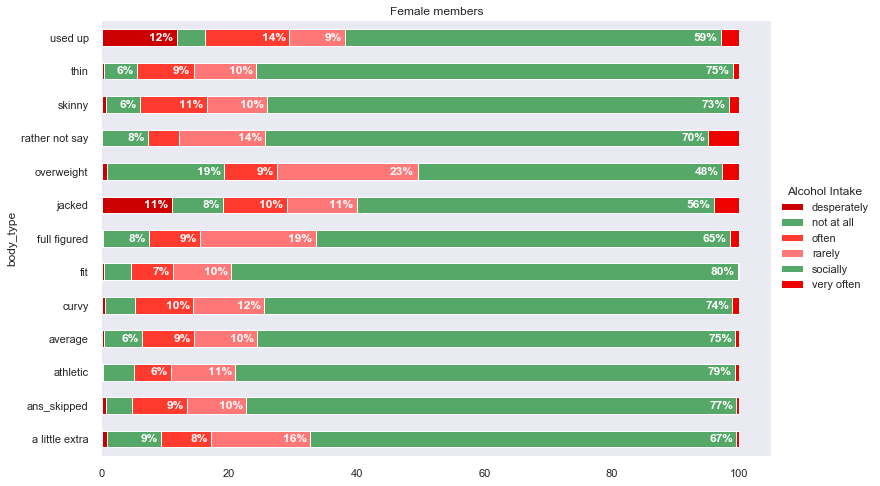

In [36]:
fitness_trn_drinks = gen_feature_specific_df(fitness_df,'body_type', 'drinks', 'm')
cols = list(fitness_trn_drinks.columns)
cols.remove('body_type')
cols.remove('sex')
cols.remove('ans_skipped')
fitness_trn_drinks = pd.pivot_table(fitness_trn_drinks, index=['body_type'],values=cols, aggfunc=np.sum)
# cols
color_list = ['#cc0000', 'g','#ff3b30','#ff7877','g', '#ee0200']
ax = custom_plot(fitness_trn_drinks, "Alcohol Intake", "Male",  color_list)


fitness_trn_drinks = gen_feature_specific_df(fitness_df,'body_type', 'drinks', 'f')
cols = list(fitness_trn_drinks.columns)
cols.remove('body_type')
cols.remove('sex')
cols.remove('ans_skipped')
fitness_trn_drinks = pd.pivot_table(fitness_trn_drinks, index=['body_type'],values=cols, aggfunc=np.sum)
# cols
color_list = ['#cc0000', 'g','#ff3b30','#ff7877','g', '#ee0200']
ax = custom_plot(fitness_trn_drinks, "Alcohol Intake", "Female", color_list)

### **What does Smoking habits say about Fitness and Obesity levels ?**

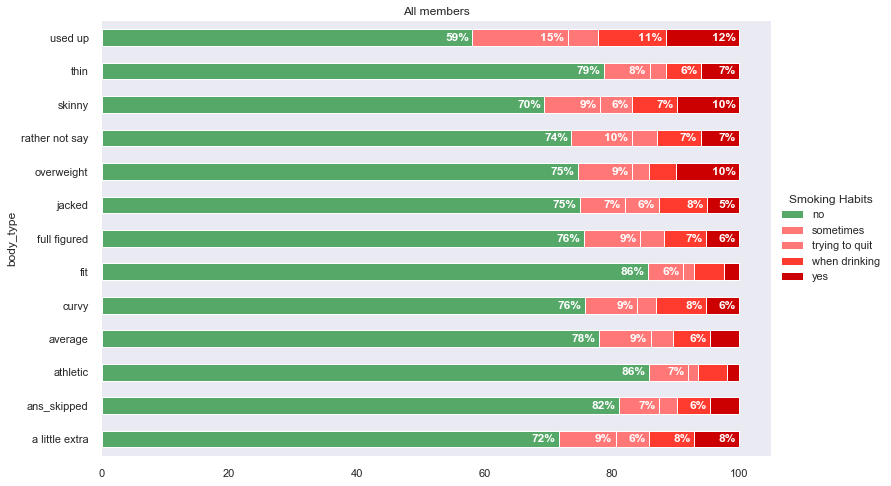

In [37]:
fitness_trn_smokes= gen_feature_specific_df(fitness_df,'body_type', 'smokes')
cols = list(fitness_trn_smokes.columns)
cols.remove('body_type')
cols.remove('sex')
cols.remove('ans_skipped')
fitness_trn_smokes = pd.pivot_table(fitness_trn_smokes, index=['body_type'],values=cols, aggfunc=np.sum)
# cols
color_list = ['g','#ff7877','#ff7877','#ff3b30', '#cc0000']
ax = custom_plot(fitness_trn_smokes, "Smoking Habits", "All", color_list)

### **What does Diet choices say about Fitness and Obesity levels ?**

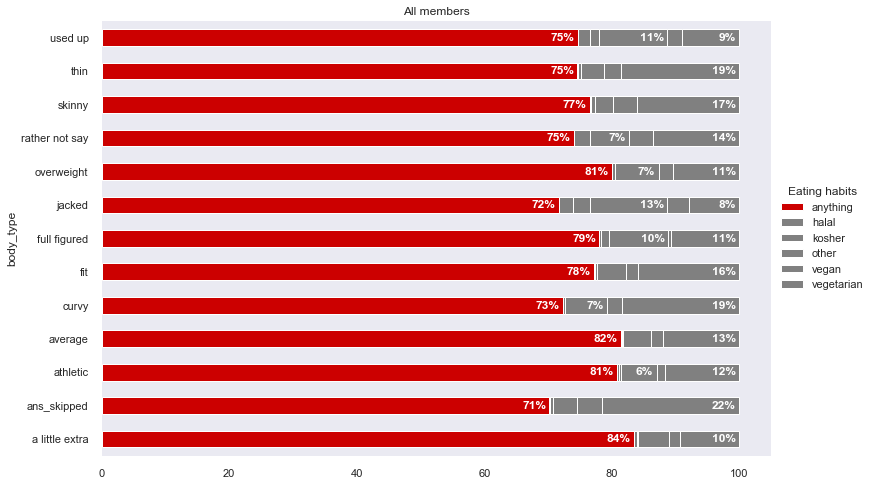

In [38]:
fitness_trn_diet= gen_feature_specific_df(fitness_df,'body_type', 'diet')
cols = list(fitness_trn_diet.columns)
cols.remove('body_type')
cols.remove('sex')
cols.remove('ans_skipped')
fitness_trn_diet = pd.pivot_table(fitness_trn_diet, index=['body_type'],values=cols, aggfunc=np.sum)
# cols
color_list = ['#cc0000', 'grey', 'grey','grey','grey', 'grey']
ax = custom_plot(fitness_trn_diet, "Eating habits", "All", color_list)

### **Has Income class anything to say about lifestyle and dietary choices ?**
* The below calculation is a conservative estimate, I understand this less for SF even in 2012 (the data is from 2012). But this still drives the point
* In 2019 65K to 192K was considered middle class in SF [source](https://www.sfgate.com/expensive-san-francisco/article/SF-household-income-192k-middle-class-median-13637536.php)

In [39]:
def get_income_group(income):
    if income <= -1:
        return "unknown"
    if income > 0 and income <= 30000:
        return "poor"
    elif income > 30001 and income <= 50000:   
        return "middle"
    elif income > 50001 and income <= 75000:   
        return "upper"
    elif income > 75001 and income <= 120000:
        return "affuent"
    elif income > 120001:
        return "wealthy"
    
fitness_df['income_class']  = fitness_df['income'].apply(get_income_group)      

### **Income class Vs Smoking ?**

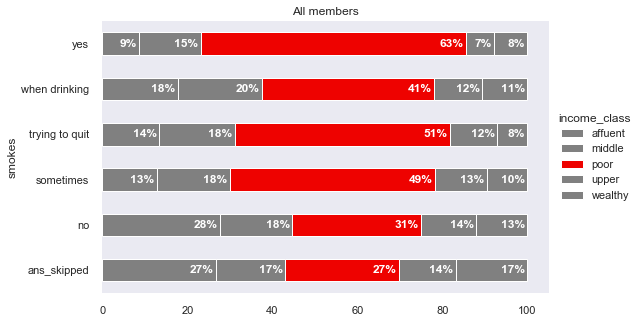

In [40]:
fitness_trn_income= gen_feature_specific_df(fitness_df[fitness_df.income > -1],'smokes', 'income_class')
cols = list(fitness_trn_income.columns)
cols.remove('smokes')
cols.remove('sex')
fitness_trn_income = pd.pivot_table(fitness_trn_income, index=['smokes'],values=cols, aggfunc=np.sum)
color_list = ['grey','grey', '#ee0200', 'grey', 'grey']
ax = custom_plot(fitness_trn_income, "income_class","All", color_list, (8,5))

### **Income class Vs Drugs ?**

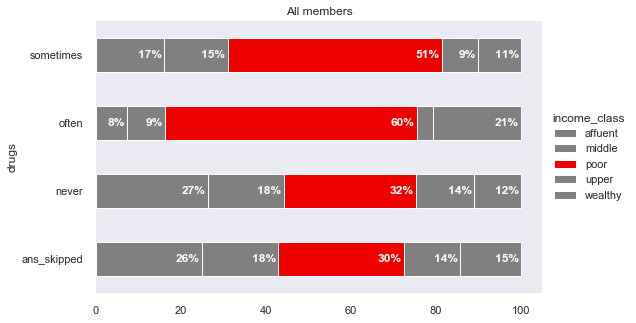

In [41]:
fitness_trn_income= gen_feature_specific_df(fitness_df[fitness_df.income > -1],'drugs', 'income_class')
cols = list(fitness_trn_income.columns)
cols.remove('drugs')
cols.remove('sex')
fitness_trn_income = pd.pivot_table(fitness_trn_income, index=['drugs'],values=cols, aggfunc=np.sum)
color_list = ['grey','grey', '#ee0200', 'grey', 'grey']
ax = custom_plot(fitness_trn_income, "income_class", "All", color_list, (8,5))

### **Income class Vs Drinks ?**

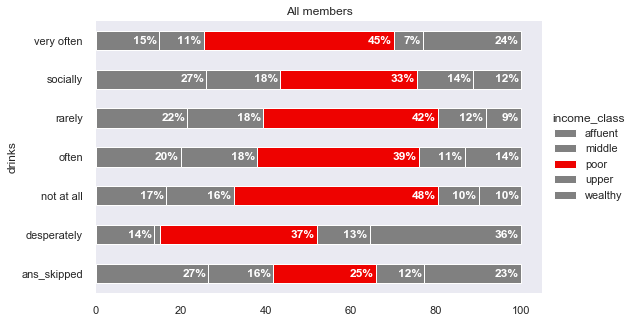

In [42]:
fitness_trn_income= gen_feature_specific_df(fitness_df[fitness_df.income > -1],'drinks', 'income_class')
cols = list(fitness_trn_income.columns)
cols.remove('drinks')
cols.remove('sex')
fitness_trn_income = pd.pivot_table(fitness_trn_income, index=['drinks'],values=cols, aggfunc=np.sum)
color_list = ['grey','grey', '#ee0200', 'grey', 'grey']
ax = custom_plot(fitness_trn_income, "income_class","All",color_list, (8,5))

### **Income class Vs Diet habits ?**

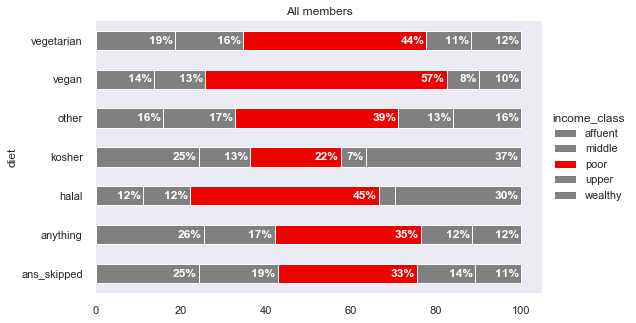

In [43]:
fitness_trn_income= gen_feature_specific_df(fitness_df[fitness_df.income > -1],'diet', 'income_class')
cols = list(fitness_trn_income.columns)
cols.remove('diet')
cols.remove('sex')
fitness_trn_income = pd.pivot_table(fitness_trn_income, index=['diet'],values=cols, aggfunc=np.sum)
color_list = ['grey','grey', '#ee0200', 'grey', 'grey']
ax = custom_plot(fitness_trn_income, "income_class","All",color_list,(8,5))

### **Income class Vs Fitness Levels or Obesity**

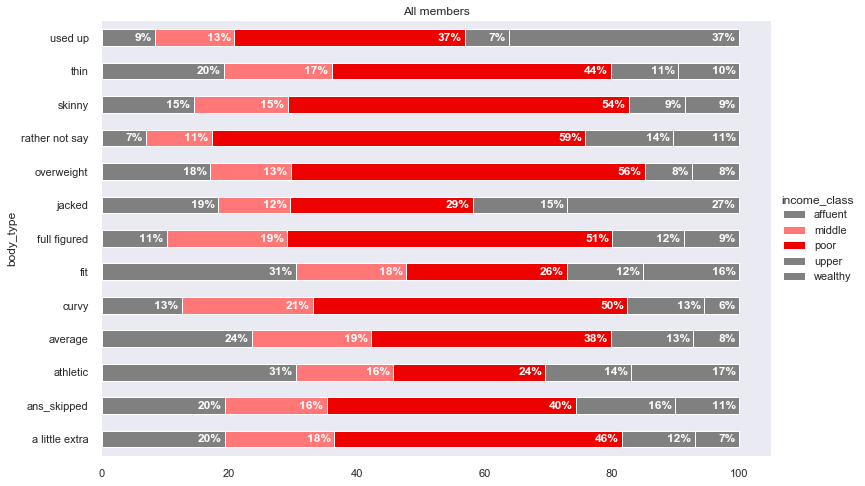

In [44]:
fitness_trn_income= gen_feature_specific_df(fitness_df[fitness_df.income > -1],'body_type', 'income_class')
cols = list(fitness_trn_income.columns)
cols.remove('body_type')
cols.remove('sex')
fitness_trn_income = pd.pivot_table(fitness_trn_income, index=['body_type'],values=cols, aggfunc=np.sum)
color_list = ['grey','#ff7877', '#ee0200', 'grey', 'grey']
ax = custom_plot(fitness_trn_income, "income_class","All",color_list)

### **Encoding Categorical features and Scaling Numerical features**

In [45]:
def encode_cat_features(df):
    
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import MinMaxScaler
    from sklearn_pandas import DataFrameMapper
    
    col_dtypes = zip(df.columns,df.dtypes)
    columns = []
    for col, dtype in col_dtypes:
        if dtype == 'O':
            columns.append((col, LabelEncoder()))
        else:
            columns.append(([col], MinMaxScaler()))

    mapper = DataFrameMapper(columns, df_out=True)
    return mapper.fit_transform(df)

In [46]:
encode_cat_features(fitness_df).sample(5)

,age,sex,education,job,offspring,location,income,diet,drinks,drugs,religion,smokes,pets,orientation,ethnicity,height,status,body_type,income_class
34305,0.294118,1,10,4,1,136,0.040001,1,5,1,2,1,15,2,16,0.571429,3,3,1
44928,0.490196,1,0,13,0,0,0.000000,0,3,1,1,0,0,2,0,0.571429,3,12,3
26878,0.313725,1,0,0,0,136,0.000000,0,0,1,1,0,0,2,11,0.657143,3,3,3
29125,0.235294,0,11,17,0,103,0.000000,0,5,0,1,1,12,2,6,0.457143,3,4,3
47715,0.196078,0,10,13,0,136,0.000000,0,5,1,1,1,15,2,16,0.514286,3,5,3


### **Correlation Heatmap**
* **Pearson correlation:** Pearson correlation is the most widely used correlation statistic to measure the degree of the relationship between linearly related variables
<center><img src="images/pearson.png" style="width:50;height:20"></img></center>
* **But Spearman correlation** is great when there is an ordinal relationship between the values of the data and the scores on one variable must be monotonically related to the other variable. Which is true in our case.
<center><img src="images/spearman.jpg" style="width:50;height:20"></img></center>

### **Spearman correlation**

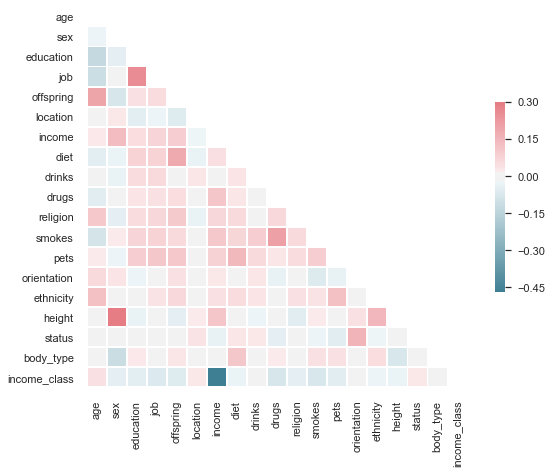

In [47]:
sns.set(style="white")


corr = encode_cat_features(fitness_df).corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### **Pearson correlation**

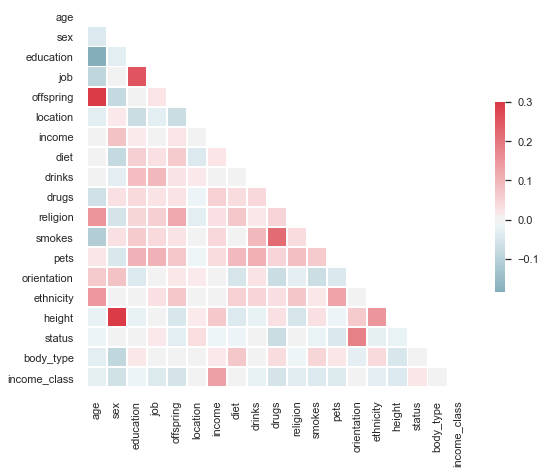

In [48]:
sns.set(style="white")


corr = encode_cat_features(fitness_df).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### **Bamboo lib PPS Heatmap**

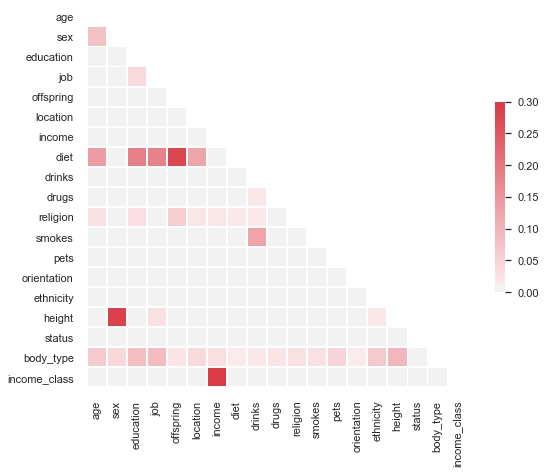

In [45]:
import ppscore as pps
df_matrix = pps.matrix(encode_cat_features(fitness_df))
f, ax = plt.subplots(figsize=(10, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(df_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### **Summary**
One correlation plot summarily suggests that there are correlations between **body type and features like diet, income, drinks, drugs, smokes and ethnicity**. Also the feature set correlations confirm our natural intuition as well for instance, drugs:smokes, sex:height, age:offspring all these pairs are strong ly and positively correlated. This will open up some interesting modelling opportunities.

----

### **Miscellaneous findings**
* **Look what I found**
* In the process of finding the the link between Income class and lifestyle, I was checking what were the top paid job with median reported income.
* Obviously CXOs and Top management are getting paid the highest next is banking followed by Tech jobs.
* Except for Tech world everywhere else women are paid lesser than men ! Thats just an observation in the fraction of the dataset.
* **But if in the purportedly progressive silicon valley if there is income equality ?**

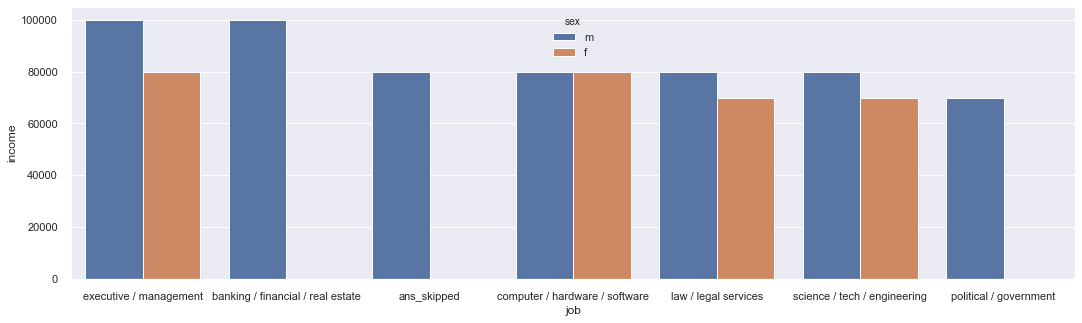

In [46]:
sns.set(rc={'figure.figsize':(18,5)})
result = fitness_df[fitness_df['income'] > -1].groupby(["job", "sex"])['income'].aggregate(np.median).reset_index().sort_values('income', ascending=False)
result = result[result['income'] >= 70000]
sns.barplot(x="job", y="income",  hue="sex", data=result)
plt.show()

* But At the same time by ethnicity Americans of Indian origin are the top paid, So there is Income inquality but not Racism or white privilege in Silicon valley ?
* **Just kidding this is a very small substrata of the population to answer these societal questions, any social scientist who is worth his/her salt would agree !**

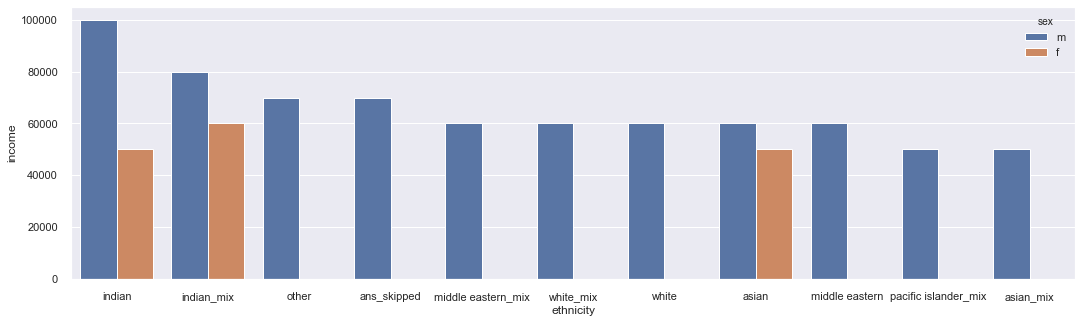

In [47]:
sns.set(rc={'figure.figsize':(18,5)})
result = fitness_df[fitness_df['income'] > -1].groupby(["ethnicity", "sex",])['income'].aggregate(np.median).reset_index().sort_values('income', ascending=False)
result = result[result['income'] >= 50000]
sns.barplot(x="ethnicity", y="income",  hue="sex", data=result)
plt.show()

* **You want to see another abomination ?**

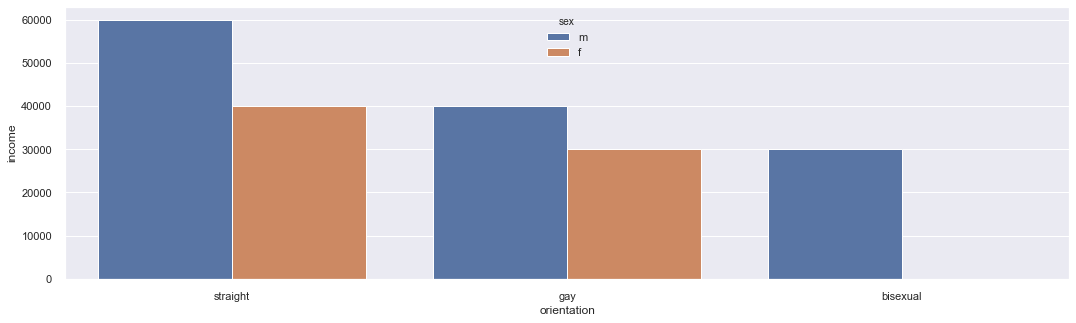

In [48]:
sns.set(rc={'figure.figsize':(18,5)})
result = fitness_df[fitness_df['income'] > -1].groupby(["orientation", "sex",])['income'].aggregate(np.median).reset_index().sort_values('income', ascending=False)
result = result[result['income'] >= 30000]
sns.barplot(x="orientation", y="income",  hue="sex", data=result)
plt.show()

### **Check if we can harvest isActive life style feature from the Essays**

* Below mental model shows how to approach a NLP problem based in the dataset
* While we could play by it, lets see if we can use a **simple rule/keyword based approach** to extract isActive feature from the essays

<img src="https://miro.medium.com/max/2000/1*fuKYhDkyPBY4f559OeftRA.png"> </img>

In [72]:
def has_active_lifestyle(essay_test):
    keywords = ['fit', 'physique', 'workout', 'gym','active', 'exercise', 'run', 'jog', 'lift', 'bike', 'swim', 'hike', 'trek', 'sport', 'athelete']
    count = 0
    for keyword in keywords:
        if keyword in essay_test.split(' '):
            count += 1
            if count >=1:
                return True
    return False   

okc_profiles['profile_text'] = okc_profiles['essay0'].fillna('') + okc_profiles['essay3'].fillna('') 
okc_profiles['isActive'] = okc_profiles['profile_text'].apply(has_active_lifestyle)
okc_profiles[okc_profiles.isActive == True].shape

(6409, 33)

In [73]:
pd.set_option('display.max_colwidth', -1)
okc_profiles[okc_profiles.isActive == True].sample(2)[['profile_text']]

,profile_text
53582,"well, right out of the gate i should let you know that i'll be\nover-seas for a little while longer. coming to san jose soon\nthough! i'll be living in the south bay for a bit. i'm from\nlafayette, so i'd like to meet some cool people in the city i'll be\ncalling home!<br />\n<br />\ni've recently decided to bring back my awesome hair. i had a short\nmilitary haircut for years, but it got old. my main picture is the\nnew and improved me!<br />\n<br />\nmy job requires me to be in excellent shape physically. healthy\nliving is pretty important to me. it's cool to have a job where i\nget paid to run and lift weights all the time. with that said,\nyou'll never see one of those douchey shirtless shots on my\nprofile.<br />\n<br />\ni have a job that i love and more than provides me with what i\nneed. i'm definitely old-fashioned in a lot of ways. some gentlemen\nfeel the need to be flashy and over-the-top, not me. i'm down to\nearth and enjoy the simplest of things in life.either my height, or my blue eyes."
12630,"equally at home in a mosh pit or mansion, i am pretty complex and\nfrustrate most people by fitting no stereotype. i have habits, but\nthese change. i generally tend to cultural and intellectual life,\nhate superficiality. though still in training, shamanic work is my\ngreater purpose in life. if your curious about this, feel free to\ncontact me. i'd say i am just a normal guy despite this; i am and i\nam not. it isn't an ego thing, most guys run for cover.<br />\n<br />\ni enjoy individual sports a lot. i am usually on my bike. i also\nhike, backpack, play tennis (badly), lift weights, swim, jog,\nkayak, boogie board, practice yoga, ski, and i am learning to surf,\no.k. i'm trying to learn.<br />\n<br />\ni am very social, really enjoy conversation, but i also spend a lot\nof my time with a few close friends and can read alone for hours/\nhike alone for days. these days i am really exploring, seeing live\nmusic, checking out minimalist dada videos. i just changed from law\nto occupational therapy.<br />\n<br />\ni am trying to fit, into a box, and can'tmy bike which appears permanently attached to my body. people think\ni bite but am really a nice guy lost in philosophical reverie."


* Simple but good enough !!

### **Binning continous attributes into ordinal categorical attributes**

In [71]:
bins = [0,20,30,40,50,60,70,80,90,100]
labels = [10,20,30,40,50,60,70,80,90]
fitness_df['age_group'] = pd.cut(fitness_df['age'], bins, labels=labels)
fitness_df[['age', 'age_group', 'sex', 'height']].sample(5)

,age,age_group,sex,height
38963,31,30,m,5.976
57481,33,30,f,5.395
11009,28,20,m,5.976
21885,26,20,f,5.063
53835,46,40,f,5.644
